In [2]:
import pandas as pd
import numpy as np
import random
import re

import os, sys, glob, pickle

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import IPython.display as ipd

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm, tqdm_pandas

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [3]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
# import pyttsx3 as pt
# import speech_recognition as sr
# import pywhatkit
# import time

# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.common.keys import Keys

# import os
# import sys
# os.system("clear")

In [4]:
audio_df = pd.read_csv('combined_data.csv')
audio_df.sample(5)

,Emotion,Path
3716,female_sad,../SER/CREMA/1006_IOM_SAD_XX.wav
4666,female_sad,../SER/CREMA/1018_DFA_SAD_XX.wav
6367,male_fear,../SER/CREMA/1038_TSI_FEA_XX.wav
2427,female_fear,../SER/TESS Toronto emotional speech set data/...
9971,female_sad,../SER/CREMA/1082_TIE_SAD_XX.wav


In [5]:
audio_df_copy = audio_df.copy()

In [6]:
audio_df.Emotion.unique()

array(['male_angry', 'male_disgust', 'male_fear', 'male_happy',
       'male_calm', 'male_sad', 'male_surprise', 'female_angry',
       'female_disgust', 'female_fear', 'female_happy', 'female_calm',
       'female_surprise', 'female_sad'], dtype=object)

In [13]:
todrop = audio_df_copy[audio_df_copy['Emotion']=='male_surprise'].index
audio_df_copy.drop(todrop,inplace=True)

In [29]:
audio_df_copy.Emotion.unique()

array(['male_angry', 'male_happy', 'male_calm', 'male_sad',
       'female_angry', 'female_happy', 'female_calm', 'female_sad'],
      dtype=object)

In [31]:
audio_df_copy.to_csv('modeldata.csv')

In [15]:
def prepare_data(df, n, mfcc):
    sampling_rate=44100
    audio_duration=2.5


    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.Path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

                
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X


In [16]:
n_mfcc = 30
mfcc = prepare_data(audio_df_copy, n = n_mfcc, mfcc = 1)

100%|██████████| 7664/7664 [10:16<00:00, 12.43it/s]


In [34]:
#  Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , audio_df_copy.Emotion
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


# one hot encode the target 



In [ ]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [44]:
y_test2=y_train


In [45]:
y_test2.to_csv('target.csv',index=False)

In [46]:
test1= pd.read_csv('../SER/target.csv')

In [47]:
test1= pd.read_csv('../SER/target.csv')
lb2 = LabelEncoder()
y_train2 = np_utils.to_categorical(lb2.fit_transform(test1))
y_train2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:

# Normalization as per the standard NN process
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 8
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(128, (2,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(128, (2,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(64
    , (2,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(64
    , (2,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=32, verbose = 2, epochs=150)

Epoch 1/150
180/180 - 459s - loss: 1.8054 - acc: 0.3112 - val_loss: 2.3451 - val_acc: 0.2584 - 459s/epoch - 3s/step
Epoch 2/150
180/180 - 444s - loss: 1.2877 - acc: 0.5064 - val_loss: 1.1286 - val_acc: 0.5945 - 444s/epoch - 2s/step
Epoch 3/150
180/180 - 440s - loss: 1.1127 - acc: 0.5729 - val_loss: 2.0284 - val_acc: 0.2991 - 440s/epoch - 2s/step
Epoch 4/150
180/180 - 440s - loss: 1.0112 - acc: 0.6131 - val_loss: 1.0774 - val_acc: 0.5814 - 440s/epoch - 2s/step
Epoch 5/150
180/180 - 438s - loss: 0.9377 - acc: 0.6336 - val_loss: 1.3005 - val_acc: 0.5219 - 438s/epoch - 2s/step
Epoch 6/150
180/180 - 469s - loss: 0.8923 - acc: 0.6656 - val_loss: 0.8508 - val_acc: 0.6759 - 469s/epoch - 3s/step
Epoch 7/150
180/180 - 444s - loss: 0.8429 - acc: 0.6806 - val_loss: 2.5183 - val_acc: 0.3523 - 444s/epoch - 2s/step
Epoch 8/150
180/180 - 442s - loss: 0.8243 - acc: 0.6820 - val_loss: 1.4200 - val_acc: 0.4572 - 442s/epoch - 2s/step
Epoch 9/150
180/180 - 440s - loss: 0.7769 - acc: 0.7015 - val_loss: 0.78

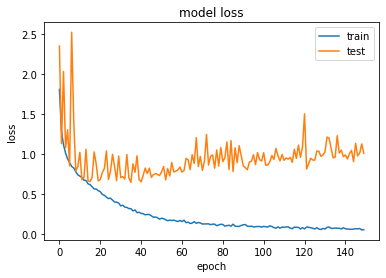

In [20]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [21]:
# serialize model to JSON
saved_model = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(saved_model)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [32]:
# # evaluate loaded model on test data
# loaded_model.compile(loss='categorical_crossentropy', optimizer='opt', metrics=['acc'])
# score = loaded_model.evaluate(X_test, y_test, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [23]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

120/120 [==============================] - 61s 499ms/step


array([6, 0, 5, ..., 6, 5, 0], dtype=int64)

In [24]:
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})


# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)

In [343]:
finaldf.sample(10)

,actualvalues,predictedvalues
1294,female_angry,female_angry
1024,female_angry,female_angry
994,female_sad,female_sad
63,female_happy,female_happy
1892,female_sad,female_sad
130,male_angry,male_angry
707,female_sad,female_sad
1498,female_sad,female_sad
1742,male_calm,male_calm
310,male_calm,male_calm


In [344]:
# print("-------COMMANDS-------\nplay music (This automatically plays music base on your mood)\nplay song_name (self choosen music or movie) \n\n--control playing song as-----\npause\nresume\nstart again")
# print("to repeat song:REPLAY")


Testing code section

In [25]:
import pyaudio
import wave
import speech_recognition as sr
recognizer = sr.Recognizer()

In [26]:
def recoreded():
    with sr.WavFile('testing.wav') as source:
        recognizer.adjust_for_ambient_noise(source)
        audio2 = recognizer.record(source)
    try: 
        s = recognizer.recognize_google(audio2,language="en")
        # print(s)
        return s
    except:
        print("I don't seems to get that!")

In [27]:
if recoreded() == 'play music':
    newinput = pd.DataFrame({'Path': ['../SER/output10.wav']})
    mfcc2 = prepare_data(newinput, n = 30, mfcc = 1)
    preds2 = loaded_model.predict(mfcc2,batch_size=16,verbose=1)
    preds2=preds2.argmax(axis=1)
    final = preds2.astype(int).flatten()
    final = (lb.inverse_transform((final)))
    print(final) #emo(final) #gender(final)
    
elif "play" in recoreded():
    print('better')
else:
    print('problem')

100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


1/1 [==============================] - 0s 89ms/step
['female_happy']


In [56]:
import re

In [345]:
n_mfcc = 30

In [346]:
nwpath = ['../SER/output10.wav']

In [347]:
#deleting  recorded file
# os.remove('../SER/testing.wav')

In [372]:
newinput = pd.DataFrame({'Path': ['../SER/output16.wav']})
newinput

,Path
0,../SER/output16.wav


In [373]:
n_mfcc = 30
mfcc2 = prepare_data(newinput, n = n_mfcc, aug = 0, mfcc = 1)

100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


In [374]:
preds2 = model.predict(mfcc2, 
                         batch_size=16, 
                         verbose=1)

preds2=preds2.argmax(axis=1)
preds2

1/1 [==============================] - 0s 84ms/step


array([3], dtype=int64)

In [375]:
final = preds2.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(final) #emo(final) #gender(final) 

['female_sad']


In [63]:
final[0].split('_')[1]

'happy'